In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_30 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.risk.final_model_loss_train_risk import *
from model.final_model.risk.final_model_risk import PatientOutcomeModel
from model.lstm.autoencoder_v3_lstm import  TSAutoencoder
from model.final_model.risk.plot import *


import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()



In [2]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)

# ## load the inbalanced dataset sampler
# labels_train = [int(dataset_train[i][5]) for i in range(len(dataset_train))]
# labels_val = [int(dataset_val[i][5]) for i in range(len(dataset_val))]
# labels_test = [int(dataset_test[i][5]) for i in range(len(dataset_test))]

# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)
# val_sampler = ImbalancedDatasetSampler(dataset_val, labels=labels_val)
# test_sampler = ImbalancedDatasetSampler(dataset_test, labels=labels_test)

## build the dataloader
# train_loader = DataLoader( dataset_train,batch_size=16,sampler=train_sampler,collate_fn=collate_fn )
# val_loader = DataLoader( dataset_val,batch_size=16,sampler=val_sampler,collate_fn=collate_fn)
# test_loader = DataLoader( dataset_test,batch_size=16,sampler=test_sampler,collate_fn=collate_fn )
train_loader = DataLoader( dataset_train,batch_size=32,shuffle=True,collate_fn=collate_fn )
val_loader = DataLoader( dataset_val,batch_size=32,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=32,shuffle=False,collate_fn=collate_fn )
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [ ]:
# from torch.utils.data import Subset


# train_loader = DataLoader( dataset_train,batch_size=32,shuffle=False,collate_fn=collate_fn )

# batch = next(iter(train_loader))
# *_, original_indices = batch
# small_ids = original_indices.tolist()

# small_subset = Subset(dataset_train, small_ids)

# small_train_loader = DataLoader(
#     small_subset,
#     batch_size=len(small_ids),
#     shuffle=True,
#     collate_fn=collate_fn
# )
# small_train_loader_p = DataLoader(
#     small_subset,
#     batch_size=len(small_ids),
#     shuffle=False,
#     collate_fn=collate_fn
# )

In [3]:

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/baseline/resampled_30/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [4]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_lstm/risk/resampled_30"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"

model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=100, save_dir=save_path, 
            gamma=150, beta=10, kappa=10,  theta=1, 
            patience = 20 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Ep30: Calculating global target P...


[Joint] Early stopping at epoch 36 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


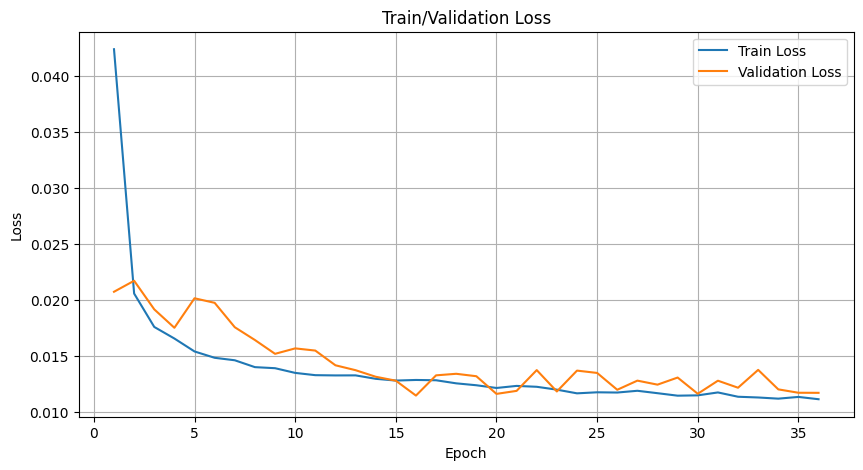

In [5]:
plot_training_history(history)

In [13]:
from sklearn.metrics import mean_squared_error, r2_score, cohen_kappa_score

def test_patient_outcome_model(model, test_loader, device):
    model.eval()
    all_risk_preds, all_risk_trues = [], []

    # record per‐patient mean predictions and true categories, for κ
    per_patient_mean_risk = []
    per_patient_cats = []

    with torch.no_grad():
        for _, flat_data, ts_data, graph_data, risk, ts_lengths, categories, _, _ in test_loader:
            flat_data, ts_data, ts_lengths = flat_data.to(device), ts_data.to(device), ts_lengths.to(device)
            graph_data = graph_data.to(device)

            # forward
            output = model(flat_data, graph_data, ts_data, ts_lengths)
            mask_seq, _ = model.generate_mask(ts_data.size(1), ts_lengths)
            mask_float = mask_seq.float()  # [B, T]

            # --- collect raw preds and truths for RMSE/R² ---
            risk_pred = output["risk_scores"]        # [B, T]
            risk_true = risk.to(device)             # [B, T]

            # flatten valid entries
            mask_flat = mask_float.view(-1).bool()
            preds_flat = risk_pred.view(-1)[mask_flat].cpu().numpy()
            trues_flat = risk_true.view(-1)[mask_flat].cpu().numpy()

            all_risk_preds.extend(preds_flat)
            all_risk_trues.extend(trues_flat)

            # --- per‐patient mean risk & category for κ ---
            sum_pred = (risk_pred * mask_float).sum(dim=1)          # [B]
            count = mask_float.sum(dim=1).clamp(min=1)              # [B]
            mean_pred = (sum_pred / count).cpu().numpy()           # [B]
            per_patient_mean_risk.extend(mean_pred.tolist())

            per_patient_cats.extend(categories.cpu().tolist())

    # --- regression metrics ---
    mse = mean_squared_error(all_risk_trues, all_risk_preds)
    rmse = mse**0.5
    r2   = r2_score(all_risk_trues, all_risk_preds)

    print(f"Test Risk    → RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # --- Cohen's κ on discrete categories (requires mapping preds → categories) ---
    # Here we assume categories ∈ {0,1,2,3}.  We discretize the mean risk prediction
    # to the nearest integer in [0,3].
    import numpy as np
    true_cats = np.array(per_patient_cats)
    # scale mean_risk from [0,1] to [0,3], then round and clip
    pred_cats = np.clip(np.round(np.array(per_patient_mean_risk) * 3), 0, 3).astype(int)
    kappa     = cohen_kappa_score(true_cats, pred_cats)

    print(f"Test Risk κ→ Cohen's κ: {kappa:.4f}")

    # per‐category loss summary (optional)
    hist_cat = {}
    losses_t = torch.tensor([
        (p - t)**2 for p, t in zip(per_patient_mean_risk, per_patient_mean_risk)  # here just placeholder
    ])  # replace with your per‐patient loss if needed
    cats_t   = torch.tensor(per_patient_cats)
    for i in range(4):
        sel = cats_t == i
        if sel.any():
            group = losses_t[sel]
            hist_cat[i] = (group.mean().item(), int(sel.sum().item()))

    return {
        "rmse": rmse,
        "r2": r2,
        "kappa": kappa,
        "per_patient_cat_loss": hist_cat,
    }


In [4]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_lstm/risk/resampled_30/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

In [5]:
output= test_patient_outcome_model(model, test_loader, device)

Test Risk    → RMSE: 0.1026, R²: 0.0386
Test Risk κ→ Cohen's κ: 0.0930


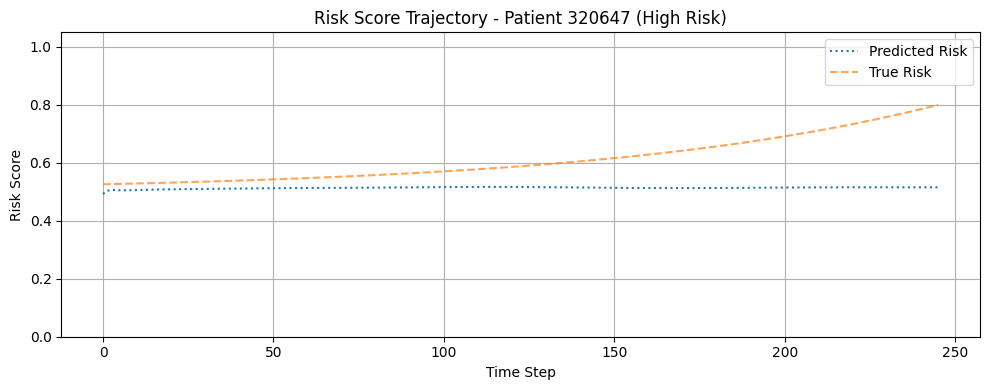

In [6]:
plot_patient_risk_score(model, test_loader, patient_index=398, device=device)

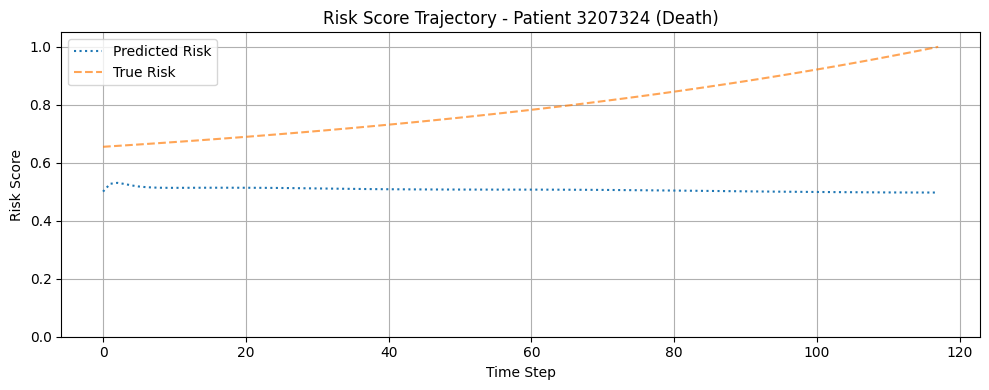

In [7]:
plot_patient_risk_score(model, test_loader, patient_index=400, device=device)

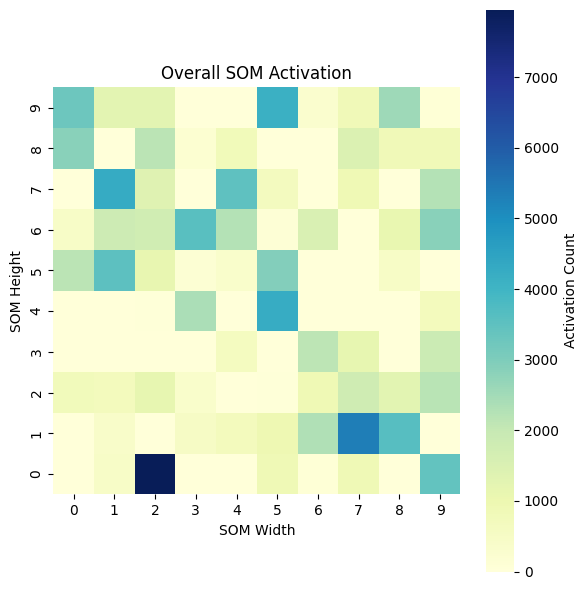

In [8]:

som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 15/15 [00:30<00:00,  2.04s/it]


--> Heatmap computation complete.


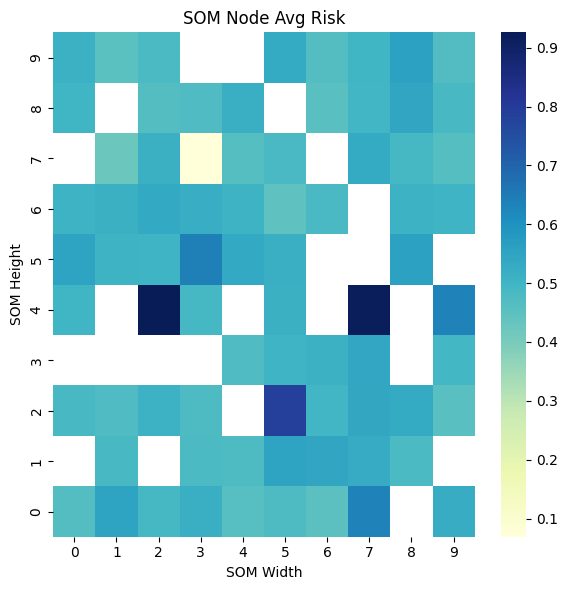

In [9]:

som_dim = (10,10)
avg_risk_map = compute_som_avg_risk(model, test_loader, device, som_dim)
plot_som_avg_risk(avg_risk_map, som_dim)

In [10]:
# --- 1. 计算热力图 ---
risk_heatmap = compute_som_avg_risk(model, test_loader, device, som_dim=(10, 10))

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 15/15 [00:30<00:00,  2.03s/it]

--> Heatmap computation complete.


In [91]:
def plot_trajectory_snapshots_custom_color(heatmap, trajectories, som_dim, snapshot_times,
                                           heatmap_cmap="YlGnBu", risk_point_cmap="coolwarm"):
    """
    Generates a series of plots showing multiple trajectories unfolding over time.
    Each trajectory has a main color based on its category, and its points are
    colored by risk at each timestep.

    Args:
        heatmap (np.ndarray): The background risk heatmap.
        trajectories (dict): Dictionary of trajectory data for one or more patients.
        som_dim (list): The dimensions of the SOM grid [H, W].
        snapshot_times (list): A list of timesteps at which to generate a plot snapshot.
        heatmap_cmap (str): Colormap for the background heatmap.
        risk_point_cmap (str): Colormap for the scatter points on the trajectory.
    """
    H, W = som_dim
    
    # --- 1. 创建子图画布 ---
    # 画布的列数等于快照的数量
    num_snapshots = len(snapshot_times)
    fig, axes = plt.subplots(1, num_snapshots, figsize=(W * num_snapshots * 0.4, H * 0.4))
    if num_snapshots == 1:
        axes = [axes] # 保证axes总是一个可迭代对象
        
    fig.suptitle("Patient Trajectory Visualization", fontsize=12, y=1.02)

    # --- 2. 准备颜色映射器 ---
    # a. 类别到主颜色的映射
    category_colors = { 0: 'green', 3: 'red', 1: 'orange', 2: 'purple' }
    default_color = 'gray'
    
    # b. 风险值到散点颜色的映射 (基于所有轨迹的全局风险范围)
    all_risks = np.concatenate([d["risk_sequence"] for d in trajectories.values() if len(d["risk_sequence"]) > 0])
    norm = Normalize(vmin=all_risks.min(), vmax=all_risks.max()) if len(all_risks) > 0 else None
    cmap_points = plt.get_cmap(risk_point_cmap)

    # --- 3. 遍历每个时间快照，绘制一个子图 ---
    for i, t in enumerate(snapshot_times):
        ax = axes[i]
        
        # a. 绘制背景热力图
        sns.heatmap(heatmap, cmap=heatmap_cmap, annot=False, cbar=True, cbar_kws={"label": "Avg Risk Score of SOM node"}, ax=ax, square=True)
        ax.invert_yaxis()
        ax.set_title(f"t = {t}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

        # b. 在当前子图上绘制所有轨迹直到时间点t的部分
        for sample_id, traj_data in trajectories.items():
            coords = traj_data["coords"]
            risks = traj_data["risk_sequence"]
            category = traj_data["category"]
            
            # 使用切片来获取从开始到当前快照时间点的所有数据
            current_t = min(t + 1, len(coords))
            if current_t == 0: continue # 如果一个点都没有，就不用画
            
            coords_slice = coords[:current_t]
            risks_slice = risks[:current_t]
            
            # 获取轨迹主颜色
            line_color = category_colors.get(category, default_color)

            # 准备坐标
            x_coords = np.array([c[0] + 0.5 for c in coords_slice])
            y_coords = np.array([c[1] + 0.5 for c in coords_slice])
            
            # 绘制轨迹线
            ax.plot(x_coords, y_coords, color=line_color, linestyle='-', linewidth=2, alpha=0.8, zorder=2)
            
            # 绘制风险着色的散点
            if norm:
                ax.scatter(x_coords, y_coords, c=risks_slice, cmap=cmap_points, norm=norm, 
                           s=50, zorder=3, ec='black', lw=0.5)

            # 只在第一个点上标记起点 'S'
            ax.plot(x_coords[0], y_coords[0], 'o', color='white', markersize=10, 
                    markeredgecolor=line_color, markeredgewidth=2, zorder=4)
            ax.text(x_coords[0], y_coords[0], 'S', color='black', ha='center', va='center', 
                    fontweight='bold', fontsize=7, zorder=5)
            
            # 在最后一个点上标记终点 'E'
            ax.plot(x_coords[-1], y_coords[-1], 'X', color=line_color, markersize=10, markeredgecolor='black', markeredgewidth=1, zorder=5)
            ax.text(x_coords[-1], y_coords[-1], 'E', color='black', ha='center', va='center',fontweight='bold', fontsize=7, zorder=6)

    # --- 4. 添加图例和共享的颜色条 ---
    # 创建一个代理图例
    legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=f'Category {cat}')
                       for cat, color in category_colors.items() if cat in [d['category'] for d in trajectories.values()]]
    start_proxy = plt.Line2D([0], [0],  marker='o', color='white', markeredgecolor='black', linestyle='None',  markersize=8, label='Start (S)')
    end_proxy   = plt.Line2D([0], [0],  marker='X', color='white',markeredgecolor='black', linestyle='None', markersize=8, label='End (E)')
    fig.legend(handles=legend_elements + [start_proxy, end_proxy], title="Patient Category", bbox_to_anchor=(0.98, 0.85), loc='center left')

    # 为风险散点创建一个共享的颜色条
    if norm:
        cbar_ax = fig.add_axes([0.85, 0.05, 0.04, 0.82]) # [left, bottom, width, height]
        sm = plt.cm.ScalarMappable(cmap=cmap_points, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.set_label('Timepoint Risk Score')

    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()

--- Searching for specified patient IDs: ['1327763'] ---


Searching for patients:   0%|          | 0/15 [00:02<?, ?it/s]

  -> Found 1 target(s) in current batch. Running forward pass...
    -> Computed trajectory for Patient ID: 1327763 (Category: 1)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [529]



/tmp/ipykernel_3914431/1268642431.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


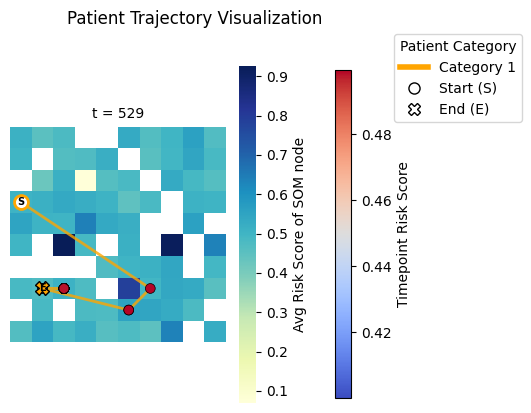

In [92]:
#cat=1
# --- 2. 计算目标病人的轨迹 ---
patient_ids =  ['1327763'] 

targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

#开始，1/4处，1/2处，3/4处，和结束前一个点
# max_len // 2,  
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['2452034'] ---


Searching for patients:  40%|████      | 6/15 [00:10<00:15,  1.70s/it]

  -> Found 1 target(s) in current batch. Running forward pass...
    -> Computed trajectory for Patient ID: 2452034 (Category: 3)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [356]



/tmp/ipykernel_3914431/1268642431.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


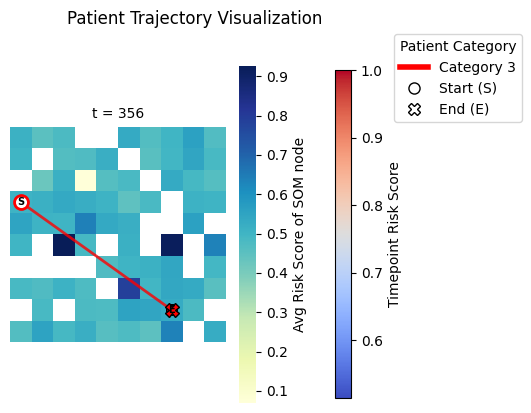

In [93]:
#cat=3
patient_ids = ['2452034'] 
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)